In [1]:
import numpy as np 
import os 
from math import pi 
from tensorflow.keras.optimizers import Adam
from ECFM_NN_helpers import create_model, generate_power_data, generate_parabolic_data,generate_random_data, generate_monotonic_data, scale_velocity, get_with_phase_input, plot_model_results, plot_historys, save_model_information
from numpy import genfromtxt
from ECFM_Validation_Helpers import model_validation_with_phase

In [2]:
matrix_file = 'ECFM_Inputs/ECFM_matrix.csv'
frequency_file = 'ECFM_Inputs/ECFM_freq.csv'
position_file = 'ECFM_Inputs/ECFM_rad.csv'
velocity_file ='ECFM_Inputs/ECFM_vel.csv'

validation_directory = 'ECFM_Validation_Inputs'
sensitivity_file = validation_directory + '/ECFM_measured_sensitivity.csv'
phase_file = validation_directory + '/ECFM_measured_phase_radian.csv'
cfd_rad_pos_file = validation_directory + '/ECFM_rad_pos.csv'
cfd_vel_profile_file = validation_directory + '/ECFM_CFD_velocity.csv'

A = np.transpose(np.vectorize(lambda t:complex(t.replace('i','j'))) (genfromtxt(matrix_file, delimiter=',',dtype='str')))
rad_pos = np.loadtxt(position_file, delimiter=',') # m
freq = np.loadtxt(frequency_file, delimiter=',') # Hz 
A = np.delete(A, -1, axis=0)
A = np.delete(A, -1, axis=0)

num_sens = A.shape[0]
num_vel = A.shape[1]

In [3]:
actual_velocity_profile = np.loadtxt(velocity_file, delimiter=',') # Hz  # m / s 
b = np.matmul(A, actual_velocity_profile)
actual_phase = np.angle(b)
sensitivity_correct =  1e-3 * np.array([0.0625, 0.1518, 0.2757, 0.3999, 0.4044, 0.3620, 0.3104, 0.2627, 0.2222, 0.1887, 0.1613, 0.1390, 0.0993, 0.0747, 0.0475])
sensitivity = np.abs(b) # V

measured_sensitivity = np.loadtxt(sensitivity_file,delimiter=',')
measured_phase = np.loadtxt(phase_file,delimiter=',').reshape(-1, 1) - pi + 0.4
measured_phase[4:10] += 2 * pi 

cfd_rad_pos = np.loadtxt(cfd_rad_pos_file, delimiter=',')
cfd_vel_profile = np.loadtxt(cfd_vel_profile_file, delimiter=',')

In [4]:
profile_type = 'Done'
profile_type += '_With_Phase'
path_to_results = profile_type + '_Velocity_Results'
path_to_model = path_to_results + '/' + profile_type + '_Model'
path_to_predicted_vel = path_to_results + '/model_velocity'
path_to_testing_vel = path_to_results + '/eval_velocity_scaled'
path_to_file = path_to_results + '/model_params.txt'


if not os.path.isdir(path_to_results): 
    os.mkdir(path_to_results)

min_vel = 0 
max_vel = 5

min_n = 5
max_n = 10 
R = 0.012827

# number of samples in the training set 
size = 8**7
test_size = 2**7
hidden_layer_activation = 'relu'
#params = ['relu', 'sigmoid', 'tanh', 'selu', 'elu']
num_nodes = (num_sens + num_vel) * 5                       
input_shape = (2 * num_sens, )
num_output = num_vel
epochs = 1
num_hidden_layers = 2
learning_rate = 2e-1
batch_size = 100
dropout_rate = 0
params = ['']

phase_shift = 0

In [5]:
# getting the training data 
train_sensitivity, train_velocity, train_phase, bs = generate_parabolic_data(A, size, min_vel, max_vel, rad_pos)#, R, min_n, max_n)
train_phase += phase_shift
# repeating the process for a validation set 
eval_sensitivity, eval_velocity, eval_phase, bs = generate_parabolic_data(A, test_size, min_vel, max_vel, rad_pos)#, R, min_n, max_n)
eval_phase += phase_shift

In [6]:
train_velocity_scaled = scale_velocity(train_velocity, max_vel)
train_input_scaled, sensitivity_scale_factor, phase_scale_factor = get_with_phase_input(train_sensitivity, train_phase)

eval_velocity_scaled = scale_velocity(eval_velocity, max_vel)
eval_input_scaled = get_with_phase_input(eval_sensitivity, eval_phase,
                                        sensitivity_scale_factor=sensitivity_scale_factor, 
                                        phase_scale_factor=phase_scale_factor)[0]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 26)                0         
                                                                 
 dense (Dense)               (None, 100)               2700      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 7)                 707       
                                                                 
Total params: 13,507
Trainable params: 13,507
Non-trainable params: 0
_________________________________________________________________


2022-08-26 12:39:14.744077: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


18875/18875 [==============================] - 14s 747us/step - loss: 0.7786 - mse: 0.7786 - mae: 0.2094 - val_loss: 0.0590 - val_mse: 0.0590 - val_mae: 0.1986
INFO:tensorflow:Assets written to: Done_With_Phase_Velocity_Results/Done_With_Phase_Model/assets
32/32 [==============================] - 0s 366us/step
Monte Carlo Uncertainty Quantification
component: 0 RMSE: 1.18 m/s NRMSE: 93%
component: 1 RMSE: 0.83 m/s NRMSE: 66%
component: 2 RMSE: 0.67 m/s NRMSE: 53%
component: 3 RMSE: 0.48 m/s NRMSE: 38%
component: 4 RMSE: 0.31 m/s NRMSE: 26%
component: 5 RMSE: 0.20 m/s NRMSE: 16%
component: 6 RMSE: 0.09 m/s NRMSE: 8%
Max Error Component: 0 RMSE: 1.18 m/s NRMSE: 93%


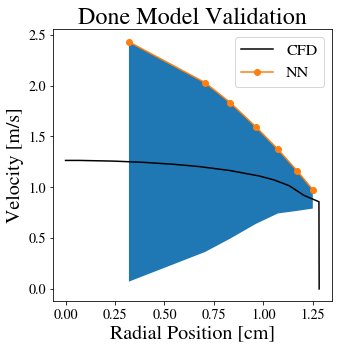

Actual Error in the Done_With_Phase model
Component: 0 MAE: 1.18 m/s NMAE: 94%
Component: 1 MAE: 0.83 m/s NMAE: 70%
Component: 2 MAE: 0.67 m/s NMAE: 57%
Component: 3 MAE: 0.48 m/s NMAE: 43%
Component: 4 MAE: 0.31 m/s NMAE: 30%
Component: 5 MAE: 0.20 m/s NMAE: 20%
Component: 6 MAE: 0.09 m/s NMAE: 10%
Average Error in profile MAE: 0.54 m/s NMAE: 46%
Max Error Component: 0  MAE: 1.18 m/s NMAE: 94%




In [7]:
historys = [] 

for param in params: 
    model = create_model(input_shape, num_output, num_nodes, 
                 num_hidden_layers=num_hidden_layers, 
                 hidden_layer_activation=hidden_layer_activation,  
                 optimizer=Adam(learning_rate=learning_rate),
                 dropout_rate=dropout_rate)

    historys.append(model.fit(
                              train_input_scaled, 
                              train_velocity_scaled, 
                              epochs=epochs, 
                              shuffle=True, 
                              verbose=1,
                              validation_split=0.1, 
                              batch_size=batch_size
                             )   
                    )
    save_model_information(
                       sensitivity_scale_factor, 
                       min_vel,
                       max_vel,
                       size, 
                       test_size, 
                       num_nodes, 
                       num_hidden_layers, 
                       hidden_layer_activation, 
                       epochs, path_to_file, 
                       batch_size, 
                       learning_rate,
                       phase_scale_factor=phase_scale_factor
                       )
    model.save(path_to_model) 
    model_validation_with_phase(profile_type, cfd_vel_profile, cfd_rad_pos, rad_pos, measured_sensitivity[:-2], measured_phase[:-2])

4/4 [==============================] - 0s 656us/step


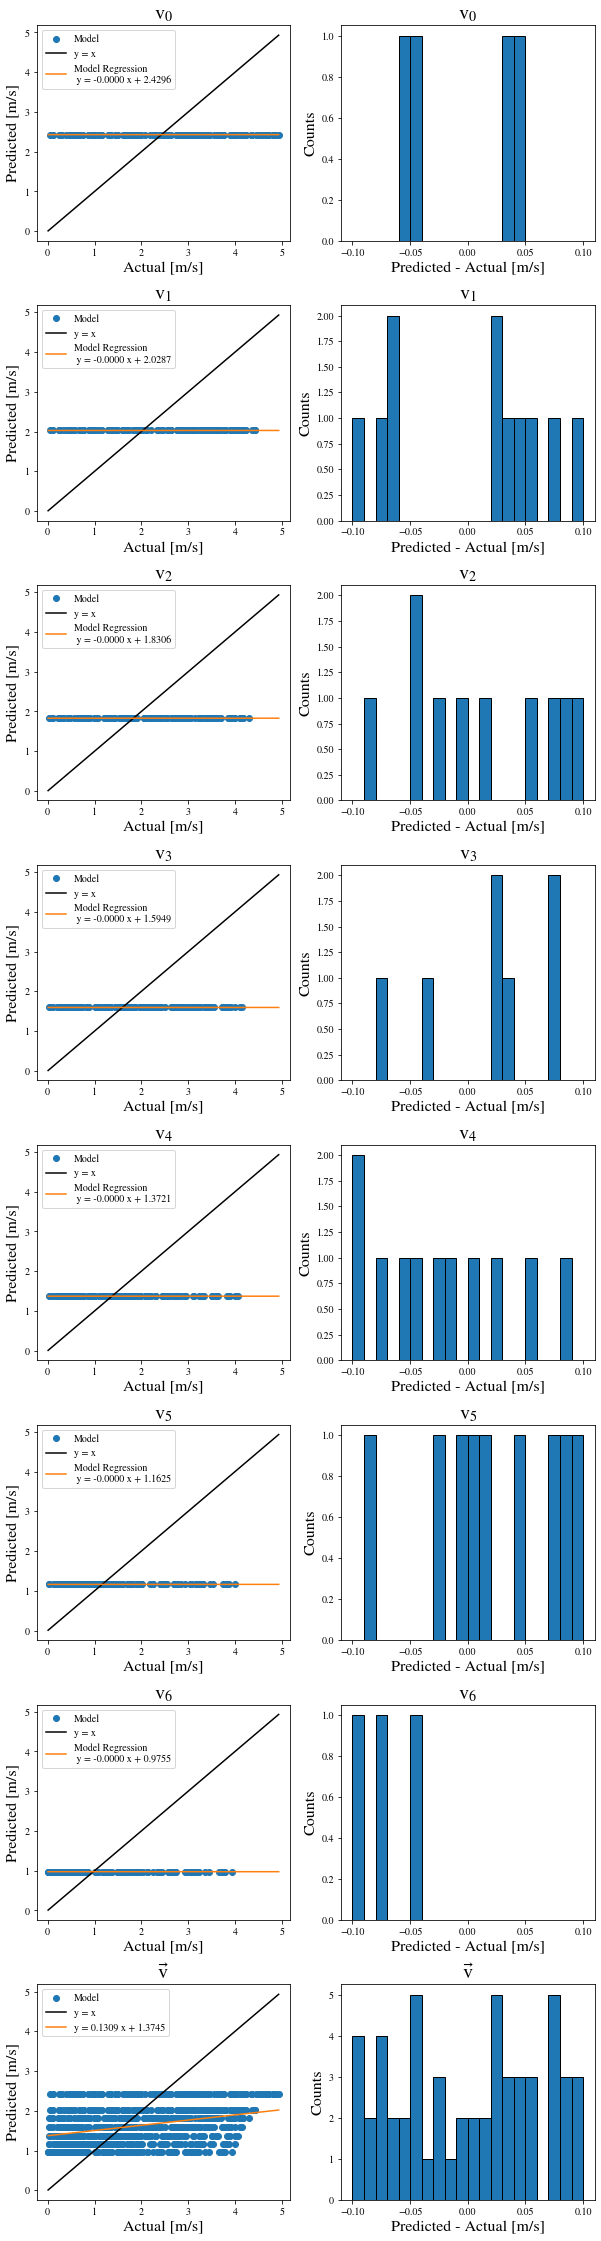

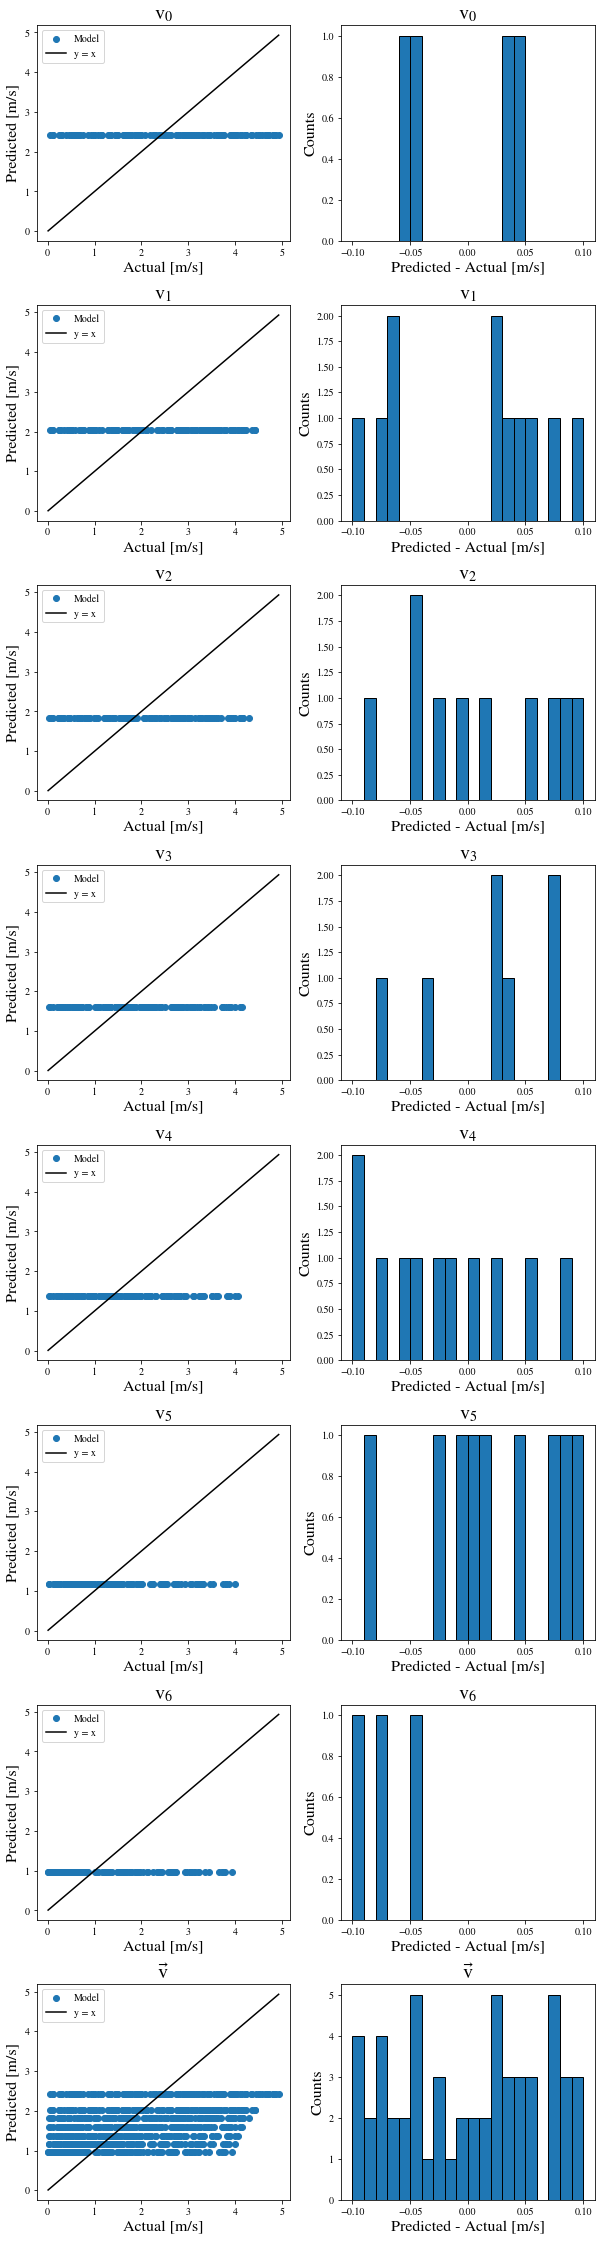

In [8]:
model_velocity = model.predict(eval_input_scaled)
plot_model_results(profile_type, eval_velocity, model_velocity * max_vel, bins=20)
plot_model_results(profile_type, eval_velocity, model_velocity * max_vel, bins=20, regression=False)

In [9]:
np.save(path_to_results + '/model_velocity', model_velocity)
np.save(path_to_results + '/eval_velocity_scaled', eval_velocity_scaled)

Final Training MSE : 7.786155E-01
Final Validation MSE : 5.900988E-02
Final Training MAE : 2.093717E-01
Final Validation MAE : 1.985970E-01




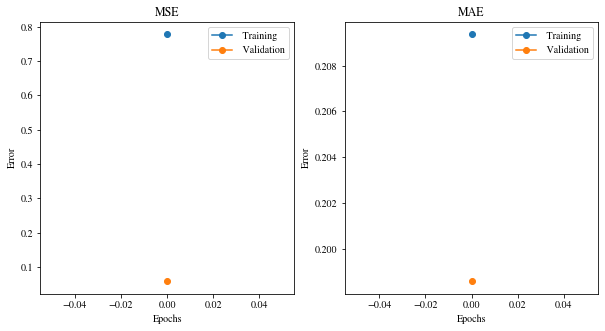

In [10]:
plot_historys(historys, params)